# Tabular Data

In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


## Dataset preparation

In [2]:
# Loading data directly from CatBoost
from catboost.datasets import amazon

X, Xt = amazon()

y = X["ACTION"].apply(lambda x: 1 if x == 1 else 0).values
X.drop(["ACTION"], axis=1, inplace=True)

In [3]:
X.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,42680,5905,117929,117930,119569,119323,123932,19793,119325


## Processing numeric data

In [4]:
import numpy as np
import pandas as pd

try:
    from sklearn.impute import IterativeImputer
except:
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold

from sklearn.pipeline import Pipeline

In [5]:
example = pd.DataFrame([[1, 2, 3, np.nan], [1, 3, np.nan, 4], [1, 2, 2, 2]], columns = ['a', 'b', 'c', 'd'])

In [6]:
def assemble_numeric_pipeline(variance_threshold=0.0, 
                              imputer='mean', 
                              multivariate_imputer=False, 
                              add_indicator=True,
                              quantile_transformer='normal',
                              scaler=True):
    numeric_pipeline = []
    if variance_threshold is not None:
        if isinstance(variance_threshold, float):
            numeric_pipeline.append(('var_filter', 
                                     VarianceThreshold(threshold=variance_threshold)))
        else:
            numeric_pipeline.append(('var_filter',
                                     VarianceThreshold()))
    if imputer is not None:
        if multivariate_imputer is True:
            numeric_pipeline.append(('imputer', 
                                     IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=100, n_jobs=-2), 
                                                      initial_strategy=imputer,
                                                      add_indicator=add_indicator)))
        else:
            numeric_pipeline.append(('imputer', 
                                     SimpleImputer(strategy=imputer, 
                                                   add_indicator=add_indicator)
                                    )
                                   )

    if quantile_transformer is not None:
        numeric_pipeline.append(('transformer',
                                 QuantileTransformer(n_quantiles=100, 
                                                     output_distribution=quantile_transformer, 
                                                     random_state=42)
                                )
                               )

    if scaler is not None:
        numeric_pipeline.append(('scaler', 
                                 StandardScaler()
                                )
                               )

    return Pipeline(steps=numeric_pipeline)

In [7]:
numeric_pipeline = assemble_numeric_pipeline(variance_threshold=0.0, 
                              imputer='mean', 
                              multivariate_imputer=False, 
                              add_indicator=True,
                              quantile_transformer='normal',
                              scaler=True)

numeric_pipeline.fit(example)

C:\Users\LucaMassaron.AzureAD\Anaconda3\envs\kaggle\lib\site-packages\sklearn\preprocessing\_data.py:2357: UserWarning: n_quantiles (100) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


Pipeline(memory=None,
         steps=[('var_filter', VarianceThreshold(threshold=0.0)),
                ('imputer',
                 SimpleImputer(add_indicator=True, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('transformer',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=100,
                                     output_distribution='normal',
                                     random_state=42, subsample=100000)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

In [8]:
np.round(numeric_pipeline.transform(example),3)

array([[-0.707,  1.225, -0.   , -0.707,  1.414],
       [ 1.414, -0.   ,  1.225,  1.414, -0.707],
       [-0.707, -1.225, -1.225, -0.707, -0.707]])

In [9]:
def derive_numeric_columns(df, pipeline):
    columns = df.columns
    if 'var_filter' in pipeline.named_steps:
        threshold = pipeline.named_steps.var_filter.threshold
        columns = columns[pipeline.named_steps.var_filter.variances_>threshold]
    if 'imputer' in pipeline.named_steps:
        missing_cols = pipeline.named_steps.imputer.indicator_.features_
        if len(missing_cols) > 0:
            columns = columns.append(columns[missing_cols] + '_missing')
    return columns

derive_numeric_columns(example, numeric_pipeline)

Index(['b', 'c', 'd', 'c_missing', 'd_missing'], dtype='object')

## Processing dates

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class DateProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, date_format='%d/%m/%Y', hours_secs=False):
        self.format = date_format
        self.columns = None
        # see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
        self.time_transformations = [
            ('day_sin', lambda x: np.sin(2*np.pi*x.dt.day/31)),
            ('day_cos', lambda x: np.cos(2*np.pi*x.dt.day/31)),
            ('dayofweek_sin', lambda x: np.sin(2*np.pi*x.dt.dayofweek/6)),
            ('dayofweek_cos', lambda x: np.cos(2*np.pi*x.dt.dayofweek/6)),
            ('month_sin', lambda x: np.sin(2*np.pi*x.dt.month/12)),
            ('month_cos', lambda x: np.cos(2*np.pi*x.dt.month/12)),
            ('year', lambda x: (x.dt.year - x.dt.year.min()) / (x.dt.year.max() - x.dt.year.min()))
        ]
        if hours_secs:
            self.time_transformations = [
                ('hour_sin', lambda x: np.sin(2*np.pi*x.dt.hour/23)),
                ('hour_cos', lambda x: np.cos(2*np.pi*x.dt.hour/23)),
                ('minute_sin', lambda x: np.sin(2*np.pi*x.dt.minute/59)),
                ('minute_cos', lambda x: np.cos(2*np.pi*x.dt.minute/59))
            ] + self.time_transformations
    
    def fit(self, X, y=None, **fit_params):
        self.columns = self.transform(X.iloc[0:1,:]).columns
        return self
    
    def transform(self, X, y=None, **fit_params):
        transformed = list()
        for col in X.columns:
            time_column = pd.to_datetime(X[col], format=self.format)
            for label, func in self.time_transformations:
                transformed.append(func(time_column))
                transformed[-1].name = transformed[-1].name + '_' + label
        transformed = pd.concat(transformed, axis=1)
        return transformed
            
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X) 

In [11]:
example = pd.DataFrame({'date_1': ['04/12/2018', '05/12/2019', '07/12/2020'],
                        'date_2': ['12/5/2018', '15/5/2015', '18/5/2016'],
                        'date_3': ['25/8/2019', '28/8/2018', '29/8/2017']})

In [12]:
DateProcessor().fit_transform(example)

,date_1_day_sin,date_1_day_cos,date_1_dayofweek_sin,date_1_dayofweek_cos,date_1_month_sin,date_1_month_cos,date_1_year,date_2_day_sin,date_2_day_cos,date_2_dayofweek_sin,...,date_2_month_sin,date_2_month_cos,date_2_year,date_3_day_sin,date_3_day_cos,date_3_dayofweek_sin,date_3_dayofweek_cos,date_3_month_sin,date_3_month_cos,date_3_year
0,0.724793,0.688967,8.660254e-01,0.5,-2.449294e-16,1.0,0.0,0.651372,-0.758758,-0.866025,...,0.5,-0.866025,1.000000,-0.937752,0.347305,-2.449294e-16,1.0,-0.866025,-0.5,1.0
1,0.848644,0.528964,1.224647e-16,-1.0,-2.449294e-16,1.0,0.5,0.101168,-0.994869,-0.866025,...,0.5,-0.866025,0.000000,-0.571268,0.820763,8.660254e-01,0.5,-0.866025,-0.5,0.5
2,0.988468,0.151428,0.000000e+00,1.0,-2.449294e-16,1.0,1.0,-0.485302,-0.874347,0.866025,...,0.5,-0.866025,0.333333,-0.394356,0.918958,8.660254e-01,0.5,-0.866025,-0.5,0.0


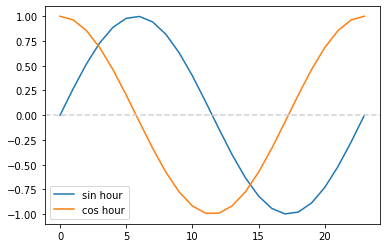

In [13]:
import matplotlib.pyplot as plt

sin_time = np.array([[t, np.sin(2*np.pi*t/23)] for t in range(0, 24)])
cos_time = np.array([[t, np.cos(2*np.pi*t/23)] for t in range(0, 24)])

plt.plot(sin_time[:,0], sin_time[:,1], label='sin hour')
plt.plot(cos_time[:,0], cos_time[:,1], label='cos hour')
plt.axhline(y=0.0, linestyle='--', color='lightgray')
plt.legend()
plt.show()

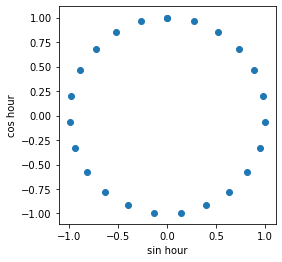

In [14]:
ax = plt.subplot()
ax.set_aspect('equal')
ax.set_xlabel('sin hour')
ax.set_ylabel('cos hour')
plt.scatter(sin_time[:,1], cos_time[:,1])
plt.show()

## Processing categorical data

In [15]:
from sklearn.preprocessing import OneHotEncoder
    
class ToString(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.astype(str)
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)
    
categorical_pipeline = Pipeline(steps=[('string_converter', ToString()),
                                       ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [16]:
example = pd.DataFrame([['car', 1234], ['house', 6543], ['tree', 3456]], columns=['object', 'code'])

In [17]:
categorical_pipeline.fit_transform(example).todense()

matrix([[1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0.]])

In [18]:
def derive_ohe_columns(df, pipeline):
    return [str(col) + '_' + str(lvl) for col, lvls in zip(df.columns, pipeline.named_steps.onehot.categories_) for lvl in lvls]

derive_ohe_columns(example, categorical_pipeline)

['object_car',
 'object_house',
 'object_tree',
 'code_1234',
 'code_3456',
 'code_6543']

## Processing ordinal data

In [19]:
from sklearn.preprocessing import OrdinalEncoder

In [20]:
example = pd.DataFrame([['first', 'very much'], ['second', 'very little'], ['third', 'average']],
                       columns = ['rank', 'importance'])

In [21]:
oe = OrdinalEncoder(categories=[['first', 'second', 'third'], ['very much', 'average', 'very little']])

categorical_pipeline = Pipeline(steps=[('string_converter', ToString()),
                                       ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
np.hstack((oe.fit_transform(example), categorical_pipeline.fit_transform(example).todense()))

matrix([[0., 0., 1., 0., 0., 0., 0., 1.],
        [1., 2., 0., 1., 0., 0., 1., 0.],
        [2., 1., 0., 0., 1., 1., 0., 0.]])

In [23]:
example.columns.tolist() + derive_ohe_columns(example, categorical_pipeline)

['rank',
 'importance',
 'rank_first',
 'rank_second',
 'rank_third',
 'importance_average',
 'importance_very little',
 'importance_very much']

## Processing high cardinality categorical data

In [24]:
from sklearn.preprocessing import LabelEncoder

class LEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.encoders = dict()
        self.dictionary_size = list()
        self.unk = -1
    
    def fit(self, X, y=None, **fit_params):
        for col in range(X.shape[1]):
            le = LabelEncoder()
            le.fit(X.iloc[:, col].fillna('_nan'))
            le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
            
            if '_nan' not in le_dict:
                max_value = max(le_dict.values())
                le_dict['_nan'] = max_value
            
            max_value = max(le_dict.values())
            le_dict['_unk'] = max_value
            
            self.unk = max_value
            self.dictionary_size.append(len(le_dict))
            col_name = X.columns[col]
            self.encoders[col_name] = le_dict
            
        return self
    
    def transform(self, X, y=None, **fit_params):
        output = list()
        for col in range(X.shape[1]):
            col_name = X.columns[col]
            le_dict = self.encoders[col_name]
            emb = X.iloc[:, col].fillna('_nan').apply(lambda x: le_dict.get(x, le_dict['_unk'])).values
            output.append(pd.Series(emb, name=col_name).astype(np.int32))
        return output

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

In [25]:
import string
import random

def random_id(length=8):
    voc = string.ascii_lowercase + string.digits
    return ''.join(random.choice(voc) for i in range(length))

example = pd.DataFrame({'high_cat_1': [random_id(length=2) for i in range(500)], 
                        'high_cat_2': [random_id(length=3) for i in range(500)], 
                        'high_cat_3': [random_id(length=4) for i in range(500)]})

In [26]:
example

,high_cat_1,high_cat_2,high_cat_3
0,7z,30i,r1ms
1,6w,ycy,08bj
2,ki,idv,jb5e
3,2v,fz0,qzut
4,ea,fwq,ytsg
...,...,...,...
495,kt,4nq,51te
496,si,2qs,zpz4
497,fb,gpm,urz5
498,3k,pfl,iuzc


In [27]:
le = LEncoder()
le.fit_transform(example)

[0       79
 1       68
 2      237
 3       28
 4      154
       ... 
 495    238
 496    331
 497    165
 498     37
 499    203
 Name: high_cat_1, Length: 500, dtype: int32,
 0       46
 1      471
 2      247
 3      209
 4      208
       ... 
 495     73
 496     43
 497    220
 498    347
 499    304
 Name: high_cat_2, Length: 500, dtype: int32,
 0      376
 1        4
 2      278
 3      373
 4      476
       ... 
 495     79
 496    491
 497    429
 498    271
 499    284
 Name: high_cat_3, Length: 500, dtype: int32]

In [28]:
le.dictionary_size

[412, 497, 502]

In [29]:
le.encoders

{'high_cat_1': {'02': 0,
  '03': 1,
  '05': 2,
  '0a': 3,
  '0c': 4,
  '0n': 5,
  '0v': 6,
  '0w': 7,
  '0x': 8,
  '12': 9,
  '18': 10,
  ...
  '_nan': 409,
  '_unk': 409},
 'high_cat_2': {'04h': 0,
  '06d': 1,
  '06o': 2,
  '07r': 3,
  '09b': 4,
  '0e7': 5,
  '0fn': 6,
  '0jk': 7,
  '0js': 8,
  '0ka': 9,
  '0ke': 10,
  '...
  '_nan': 494,
  '_unk': 494},
 'high_cat_3': {'00xd': 0,
  '01v3': 1,
  '02y3': 2,
  '05hh': 3,
  '08bj': 4,
  '0dnb': 5,
  '0fpz': 6,
  '0m6s': 7,
  '0m8o': 8,
  '0md4': 9,
  '0mgo': 10,
  '...
  '_nan': 499,
  '_unk': 499}}

## Wrapping everything up

In [30]:
from sklearn.pipeline import FeatureUnion

class TabularTransformer(BaseEstimator, TransformerMixin):
    
    def instantiate(self, param):
        if isinstance(param, str):
            return [param]
        elif isinstance(param, list):
            return param
        else:
            return None
    
    def __init__(self, numeric=None, dates=None, ordinal=None, cat=None, highcat=None,
                 variance_threshold=0.0, missing_imputer='mean', use_multivariate_imputer=False,
                 add_missing_indicator=True, quantile_transformer='normal', scaler=True,
                 ordinal_categories='auto', date_format='%d/%m/%Y', hours_secs=False):
        
        self.numeric = self.instantiate(numeric)
        self.dates = self.instantiate(dates)
        self.ordinal = self.instantiate(ordinal)
        self.cat  = self.instantiate(cat)
        self.highcat = self.instantiate(highcat)
        self.columns = None
        self.vocabulary = None
        
        self.numeric_process = assemble_numeric_pipeline(variance_threshold=variance_threshold, 
                                                         imputer=missing_imputer, 
                                                         multivariate_imputer=use_multivariate_imputer, 
                                                         add_indicator=add_missing_indicator,
                                                         quantile_transformer=quantile_transformer,
                                                         scaler=scaler)
        self.dates_process = DateProcessor(date_format=date_format, hours_secs=hours_secs)
        self.ordinal_process = FeatureUnion([('ordinal', OrdinalEncoder(categories=ordinal_categories)),
                                             ('categorial', Pipeline(steps=[('string_converter', ToString()),
                                                  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                                  ('onehot', OneHotEncoder(handle_unknown='ignore'))]))])
        self.cat_process = Pipeline(steps=[('string_converter', ToString()),
                                           ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                           ('onehot', OneHotEncoder(handle_unknown='ignore'))])
        self.highcat_process = LEncoder()
        
    def fit(self, X, y=None, **fit_params):
        self.columns = list()
        if self.numeric:
            self.numeric_process.fit(X[self.numeric])
            self.columns += derive_numeric_columns(X[self.numeric], 
                                                   self.numeric_process).to_list()
        if self.dates:
            self.dates_process.fit(X[self.dates])
            self.columns += self.dates_process.columns.to_list()
        if self.ordinal:
            self.ordinal_process.fit(X[self.ordinal])
            self.columns += self.ordinal + derive_ohe_columns(X[self.ordinal], 
                                                             self.ordinal_process.transformer_list[1][1])
        if self.cat:
            self.cat_process.fit(X[self.cat])
            self.columns += derive_ohe_columns(X[self.cat], 
                                               self.cat_process)
        if self.highcat:
            self.highcat_process.fit(X[self.highcat])
            self.vocabulary = dict(zip(self.highcat, self.highcat_process.dictionary_size))
            self.columns = [self.columns, self.highcat]
        return self
    
    def transform(self, X, y=None, **fit_params):
        flat_matrix = list()
        if self.numeric:
            flat_matrix.append(self.numeric_process.transform(X[self.numeric])
                               .astype(np.float32))
        if self.dates:
            flat_matrix.append(self.dates_process.transform(X[self.dates])
                               .values
                               .astype(np.float32))
        if self.ordinal:
            flat_matrix.append(self.ordinal_process.transform(X[self.ordinal])
                               .todense()
                               .astype(np.float32))
        if self.cat:
            flat_matrix.append(self.cat_process.transform(X[self.cat])
                               .todense()
                               .astype(np.float32))
        if self.highcat:
            cat_vectors = self.highcat_process.transform(X[self.highcat])
            if len(flat_matrix) > 0:
                return [np.hstack(flat_matrix)] + cat_vectors
            else:
                return cat_vectors
        else:
            return np.hstack(flat_matrix)

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

In [31]:
example = pd.concat([pd.DataFrame([[1, 2, 3, np.nan], [1, 3, np.nan, 4], [1, 2, 2, 2]], columns = ['a', 'b', 'c', 'd']),
                     pd.DataFrame({'date_1': ['04/12/2018', '05/12/2019', '07/12/2020'],
                                    'date_2': ['12/5/2018', '15/5/2015', '18/5/2016'],
                                    'date_3': ['25/8/2019', '28/8/2018', '29/8/2017']}),
                     pd.DataFrame([['first', 'very much'], ['second', 'very little'], ['third', 'average']],
                                   columns = ['rank', 'importance']),
                     pd.DataFrame([['car', 1234], ['house', 6543], ['tree', 3456]], columns=['object', 'code']),
                     pd.DataFrame({'high_cat_1': [random_id(length=2) for i in range(3)], 
                                    'high_cat_2': [random_id(length=3) for i in range(3)], 
                                    'high_cat_3': [random_id(length=4) for i in range(3)]})
                    ], axis=1)

numeric_vars = ['a', 'b', 'c', 'd']
date_vars = ['date_1', 'date_2', 'date_3']
ordinal_vars = ['rank', 'importance']
cat_vars = ['object', 'code']
highcat_vars = ['high_cat_1', 'high_cat_2', 'high_cat_3']

In [32]:
tt = TabularTransformer(numeric=numeric_vars, dates=date_vars, ordinal=ordinal_vars, cat=cat_vars, highcat=highcat_vars)

In [33]:
input_list = tt.fit_transform(example)

C:\Users\LucaMassaron.AzureAD\Anaconda3\envs\kaggle\lib\site-packages\sklearn\preprocessing\_data.py:2357: UserWarning: n_quantiles (100) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [34]:
print([(item.shape, item.dtype) for item in input_list])

[((3, 40), dtype('float32')), ((3,), dtype('int32')), ((3,), dtype('int32')), ((3,), dtype('int32'))]


In [35]:
tt.columns

[['b',
  'c',
  'd',
  'c_missing',
  'd_missing',
  'date_1_day_sin',
  'date_1_day_cos',
  'date_1_dayofweek_sin',
  'date_1_dayofweek_cos',
  'date_1_month_sin',
  'date_1_month_cos',
  'date_1_year',
  'date_2_day_sin',
  'date_2_day_cos',
  'date_2_dayofweek_sin',
  'date_2_dayofweek_cos',
  'date_2_month_sin',
  'date_2_month_cos',
  'date_2_year',
  'date_3_day_sin',
  'date_3_day_cos',
  'date_3_dayofweek_sin',
  'date_3_dayofweek_cos',
  'date_3_month_sin',
  'date_3_month_cos',
  'date_3_year',
  'rank',
  'importance',
  'rank_first',
  'rank_second',
  'rank_third',
  'importance_average',
  'importance_very little',
  'importance_very much',
  'object_car',
  'object_house',
  'object_tree',
  'code_1234',
  'code_3456',
  'code_6543'],
 ['high_cat_1', 'high_cat_2', 'high_cat_3']]

In [36]:
tt.vocabulary

{'high_cat_1': 5, 'high_cat_2': 5, 'high_cat_3': 5}

## Setting up a Generator

In [37]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    """
    Generates data for Keras
    """
    def __init__(self, X, y,
                 tabular_transformer=None,
                 batch_size=32, 
                 shuffle=False,
                 dict_output=False
                 ):
        
        'Initialization'
        self.X = X
        self.y = y
        self.tbt = tabular_transformer
        self.tabular_transformer = tabular_transformer
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dict_output = dict_output
        self.indexes = self._build_index()
        self.on_epoch_end()
        self.item = 0
    
    def _build_index(self):
        """
        Builds an index from data
        """
        return np.arange(len(self.y))
    
    def on_epoch_end(self):
        """
        At the end of every epoch, shuffle if required
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        """
        Returns the number of batches per epoch
        """
        return int(len(self.indexes) / self.batch_size) + 1
    
    
    def __iter__(self):
        """
        returns an iterable
        """
        for i in range(self.__len__()):
            self.item = i
            yield self.__getitem__(index=i)
            
        self.item = 0
        
    def __next__(self):
        return self.__getitem__(index=self.item)
    
    def __call__(self):
        return self.__iter__()
            
    def __data_generation(self, selection):
        if self.tbt is not None:
            if self.dict_output:
                dct = {'input_'+str(j) : arr for j, arr in enumerate(self.tbt.transform(self.X.iloc[selection, :]))}
                return dct, self.y[selection]
            else:
                return self.tbt.transform(self.X.iloc[selection, :]), self.y[selection]
        else:
            return self.X.iloc[selection, :], self.y[selection]
        
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        samples, labels = self.__data_generation(indexes)
        return samples, labels, [None]

## Creating custom activations

In [38]:
from tensorflow import keras as keras
import numpy as np
import matplotlib.pyplot as plt

In [39]:
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

keras.utils.get_custom_objects().update({'gelu': keras.layers.Activation(gelu)})

In [40]:
def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

keras.utils.get_custom_objects().update({'mish': keras.layers.Activation(mish)})

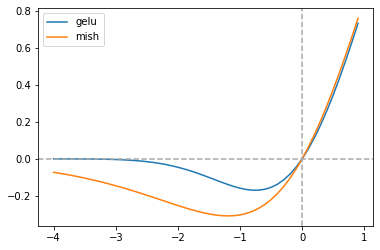

In [41]:
gelu_vals = list()
mish_vals = list()
abscissa = np.arange(-4, 1, 0.1)
for val in abscissa:
    gelu_vals.append(gelu(tf.cast(val, tf.float32)).numpy())
    mish_vals.append(mish(tf.cast(val, tf.float32)).numpy())
    
plt.plot(abscissa, gelu_vals, label='gelu')
plt.plot(abscissa, mish_vals, label='mish')
plt.axvline(x=0.0, linestyle='--', color='darkgray')
plt.axhline(y=0.0, linestyle='--', color='darkgray')
plt.legend()
plt.show()

## Test run on a difficult problem

In [42]:
import tensorflow as tf
import tensorflow.keras as keras

In [43]:
# Loading data directly from CatBoost
from catboost.datasets import amazon

X, Xt = amazon()

y = X["ACTION"].apply(lambda x: 1 if x == 1 else 0).values
X.drop(["ACTION"], axis=1, inplace=True)

In [44]:
def dnn(categorical_variables, categorical_counts,
        feature_selection_dropout=0.2, categorical_dropout=0.1,
        first_dense = 256, second_dense = 256, dense_dropout = 0.2, 
        activation_type=gelu):
    
    categorical_inputs = []
    categorical_embeddings = []
    
    for category in categorical_variables:
        categorical_inputs.append(keras.layers.Input(shape=[1], 
                                                     name=category))
        category_counts = categorical_counts[category]
        categorical_embeddings.append(
            keras.layers.Embedding(category_counts+1, 
                      int(np.log1p(category_counts)+1), 
                      name = category + "_embed")(categorical_inputs[-1]))
    
    def flatten_dropout(x, categorical_dropout):
        return keras.layers.Flatten()(keras.layers.SpatialDropout1D(categorical_dropout)(x))
    
    categorical_logits = [flatten_dropout(cat_emb, categorical_dropout) for cat_emb in categorical_embeddings]
    categorical_concat = keras.layers.Concatenate(name = "categorical_concat")(categorical_logits)

    x = keras.layers.Dense(first_dense, activation=activation_type)(categorical_concat)
    x = keras.layers.Dropout(dense_dropout)(x)  
    x = keras.layers.Dense(second_dense, activation=activation_type)(x)
    x = keras.layers.Dropout(dense_dropout)(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(categorical_inputs, output)
    
    return model

In [45]:
from sklearn.metrics import average_precision_score, roc_auc_score

def mAP(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.double)

def auc(y_true, y_pred):
    try:
        return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)
    except: 
        return 0.5

def compile_model(model, loss, metrics, optimizer):
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

def plot_keras_history(history, measures):
    """
    history: Keras training history
    measures = list of names of measures
    """
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)

Train for 43 steps, validate on 10923 samples
Epoch 1/30
43/43 - 3s - loss: 0.6816 - auc: 0.5138 - mAP: 0.9438 - val_loss: 0.6666 - val_auc: 0.5207 - val_mAP: 0.9461
Epoch 2/30
43/43 - 1s - loss: 0.6487 - auc: 0.5531 - mAP: 0.9510 - val_loss: 0.6278 - val_auc: 0.5441 - val_mAP: 0.9500
Epoch 3/30
43/43 - 1s - loss: 0.6002 - auc: 0.5788 - mAP: 0.9537 - val_loss: 0.5683 - val_auc: 0.5607 - val_mAP: 0.9528
Epoch 4/30
43/43 - 1s - loss: 0.5279 - auc: 0.6047 - mAP: 0.9583 - val_loss: 0.4839 - val_auc: 0.5771 - val_mAP: 0.9555
Epoch 5/30
43/43 - 1s - loss: 0.4347 - auc: 0.6292 - mAP: 0.9605 - val_loss: 0.3863 - val_auc: 0.5964 - val_mAP: 0.9583
Epoch 6/30
43/43 - 1s - loss: 0.3402 - auc: 0.6542 - mAP: 0.9644 - val_loss: 0.3022 - val_auc: 0.6189 - val_mAP: 0.9612
Epoch 7/30
43/43 - 1s - loss: 0.2694 - auc: 0.6841 - mAP: 0.9682 - val_loss: 0.2493 - val_auc: 0.6445 - val_mAP: 0.9643
Epoch 8/30
43/43 - 1s - loss: 0.2294 - auc: 0.7174 - mAP: 0.9726 - val_loss: 0.2232 - val_auc: 0.6724 - val_mAP: 0

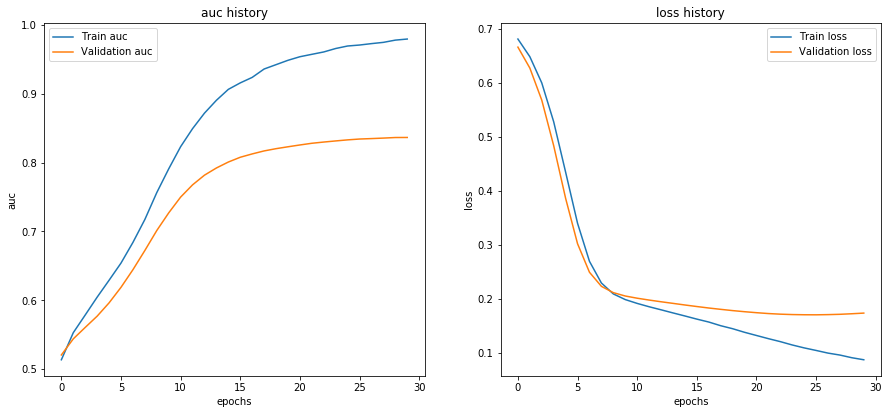

Train for 43 steps, validate on 10923 samples
Epoch 1/30
43/43 - 3s - loss: 0.6796 - auc: 0.5048 - mAP: 0.9436 - val_loss: 0.6648 - val_auc: 0.5285 - val_mAP: 0.9492
Epoch 2/30
43/43 - 1s - loss: 0.6472 - auc: 0.5449 - mAP: 0.9504 - val_loss: 0.6247 - val_auc: 0.5465 - val_mAP: 0.9519
Epoch 3/30
43/43 - 1s - loss: 0.5964 - auc: 0.5691 - mAP: 0.9528 - val_loss: 0.5609 - val_auc: 0.5647 - val_mAP: 0.9544
Epoch 4/30
43/43 - 1s - loss: 0.5194 - auc: 0.5980 - mAP: 0.9574 - val_loss: 0.4705 - val_auc: 0.5822 - val_mAP: 0.9567
Epoch 5/30
43/43 - 1s - loss: 0.4217 - auc: 0.6200 - mAP: 0.9605 - val_loss: 0.3695 - val_auc: 0.6011 - val_mAP: 0.9593
Epoch 6/30
43/43 - 1s - loss: 0.3269 - auc: 0.6448 - mAP: 0.9629 - val_loss: 0.2876 - val_auc: 0.6243 - val_mAP: 0.9621
Epoch 7/30
43/43 - 1s - loss: 0.2596 - auc: 0.6882 - mAP: 0.9690 - val_loss: 0.2398 - val_auc: 0.6498 - val_mAP: 0.9652
Epoch 8/30
43/43 - 1s - loss: 0.2246 - auc: 0.7140 - mAP: 0.9725 - val_loss: 0.2180 - val_auc: 0.6756 - val_mAP: 0

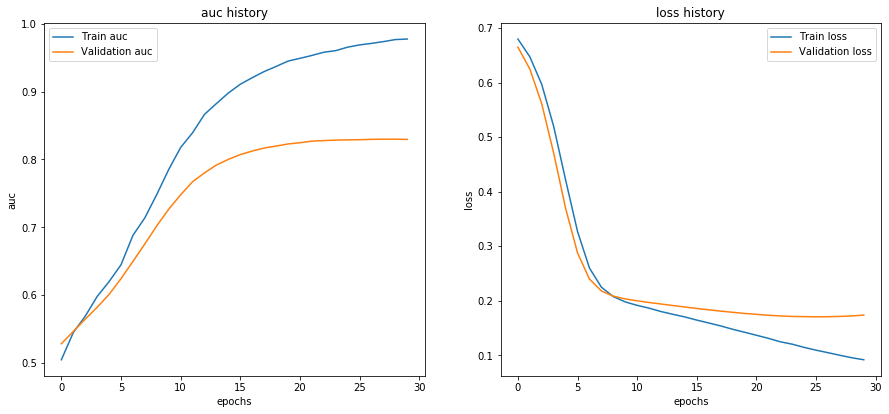

Train for 43 steps, validate on 10923 samples
Epoch 1/30
43/43 - 3s - loss: 0.6802 - auc: 0.5077 - mAP: 0.9437 - val_loss: 0.6656 - val_auc: 0.5183 - val_mAP: 0.9431
Epoch 2/30
43/43 - 1s - loss: 0.6475 - auc: 0.5321 - mAP: 0.9468 - val_loss: 0.6266 - val_auc: 0.5339 - val_mAP: 0.9452
Epoch 3/30
43/43 - 1s - loss: 0.5978 - auc: 0.5457 - mAP: 0.9490 - val_loss: 0.5649 - val_auc: 0.5494 - val_mAP: 0.9481
Epoch 4/30
43/43 - 1s - loss: 0.5217 - auc: 0.5751 - mAP: 0.9540 - val_loss: 0.4755 - val_auc: 0.5689 - val_mAP: 0.9516
Epoch 5/30
43/43 - 1s - loss: 0.4228 - auc: 0.6066 - mAP: 0.9577 - val_loss: 0.3735 - val_auc: 0.5908 - val_mAP: 0.9554
Epoch 6/30
43/43 - 1s - loss: 0.3266 - auc: 0.6321 - mAP: 0.9616 - val_loss: 0.2903 - val_auc: 0.6139 - val_mAP: 0.9590
Epoch 7/30
43/43 - 1s - loss: 0.2596 - auc: 0.6701 - mAP: 0.9664 - val_loss: 0.2423 - val_auc: 0.6391 - val_mAP: 0.9625
Epoch 8/30
43/43 - 1s - loss: 0.2245 - auc: 0.7095 - mAP: 0.9709 - val_loss: 0.2205 - val_auc: 0.6687 - val_mAP: 0

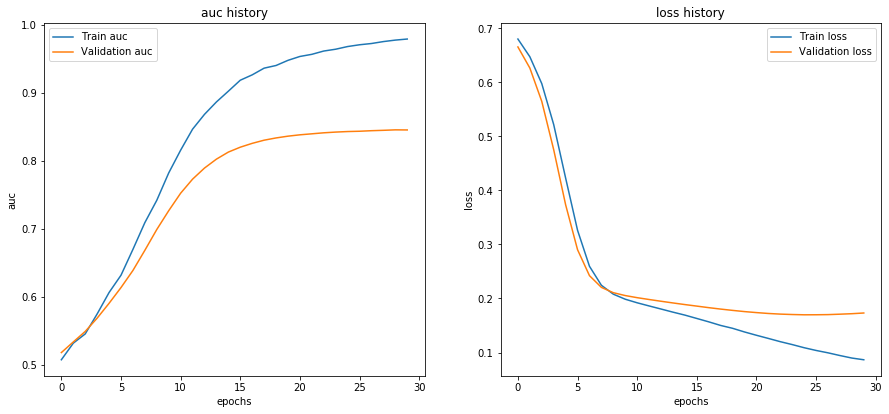

mean cv roc auc 0.840
mean cv average precision 0.985


In [46]:
from sklearn.model_selection import StratifiedKFold

SEED = 0
FOLDS = 3
BATCH_SIZE = 512

skf = StratifiedKFold(n_splits=FOLDS, 
                      shuffle=True, 
                      random_state=SEED)

roc_auc = list()
average_precision = list()
categorical_variables = X.columns.to_list()

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    
    tt = TabularTransformer(highcat = categorical_variables)

    tt.fit(X.iloc[train_idx])   
    categorical_levels = tt.vocabulary
    
    model = dnn(categorical_variables,
                categorical_levels, 
                feature_selection_dropout=0.1,
                categorical_dropout=0.1,
                first_dense=64,
                second_dense=64,
                dense_dropout=0.1,
                activation_type=mish)
    
    model = compile_model(model, 
                          keras.losses.binary_crossentropy, 
                          [auc, mAP], 
                          tf.keras.optimizers.Adam(learning_rate=0.0001))
    
    train_batch = DataGenerator(X.iloc[train_idx], 
                                y[train_idx],
                                tabular_transformer=tt,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
    
    val_X, val_y = tt.transform(X.iloc[test_idx]), y[test_idx]
    
    history = model.fit(train_batch,
                        validation_data=(val_X, val_y),
                        epochs=30,
                        class_weight=[1.0, (np.sum(y==0) / np.sum(y==1))],
                        verbose=2)
    
    print("\nFOLD %i" % fold)
    plot_keras_history(history, measures=['auc', 'loss'])
    
    preds = model.predict(val_X, verbose=0, batch_size=1024).flatten()

    roc_auc.append(roc_auc_score(y_true=val_y, y_score=preds))
    average_precision.append(average_precision_score(y_true=val_y, y_score=preds))
    
print(f"mean cv roc auc {np.mean(roc_auc):0.3f}")
print(f"mean cv average precision {np.mean(average_precision):0.3f}")